# Training neural network to predict ball position in a 3d space
## 1. Importing Libraries

In [84]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from utils.evaluate import evaluate_model
from utils.plot_maker_gaussian_process import plot_maker_3d

## 2. Loading Data
The input data are 7 cameras each with a x and y coordinate of where the ball is in the camera's frame. The output data is the x, y and z coordinate of the ball in the 3d space.
To get the input data from the recordings I used the following notebook: ../DataProcessing/StoreDataOfAllRecordings.ipynb

In the input data I recorded the following trajectories:
- Lissajous curve
- Spirograph motion
- ButterFly motion
- Hypotrachoid motion

The input data had a lot of NaN values because the angle of the camera was 20 degrees. The view is wider but so obviously the ball is less visible at all cameras at the same time. To solve this issue firstly I removed all rows where the ball was not visible on more than 2 cameras. Then I used the interpolation method from utils.interpolation import interpolate_dataframe(df). This method interpolates the NaN values in the dataframe and applies KNN to the remaining NaN values. So no more NaN values remain in the dataframe. The interpolation works quite good because I removed the bad rows so there were not to many rows left to interpolate. The interpolation method is definitely not perfect but the neural net can still learn the trajectory.

In [85]:
X = pd.read_csv('../data-7cam-20/all/red_ball_all_int_20deg.csv', decimal='.', delimiter=',')
y = pd.read_csv('../data-7cam-20/all/positions_all_int_20deg.csv', decimal='.', delimiter=',')
X.shape, y.shape

((4074, 14), (4074, 3))

## 3. Preprocessing

In [86]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

## 4. Hyperparameter tuning

In [87]:
pipeline = Pipeline([
    ('mlp', MLPRegressor())
])

In [88]:
#param_grid = {
#    'mlp__hidden_layer_sizes': [ (50, 100, 50)],
#    'mlp__activation': ['identity', 'tanh', 'relu'],
#    'mlp__solver': ['sgd', 'adam'],
#    'mlp__alpha': [0.001, 0.01, 0.1],
#    'mlp__max_iter': [10000, 20000, 28000],
#    'mlp__learning_rate': ['constant', 'adaptive'],
#    'mlp__learning_rate_init': [0.001, 0.01, 0.1],
#    'mlp__early_stopping': [True],
#}
#random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

### 4.1 Training

In [89]:
model = MLPRegressor(solver='adam', max_iter=20000, learning_rate_init=0.001, learning_rate='adaptive', hidden_layer_sizes=(50,100,50), early_stopping=True, alpha=0.01, activation='tanh')

In [90]:
#random_search.fit(X_scaled, y_scaled)

### 4.2 Best parameters

In [91]:
#print(f'Best parameters: {random_search.best_params_}')

In [92]:
#print(f'Best score: {random_search.best_score_}')

### 5. Training the model

In [93]:
#model = random_search.best_estimator_

In [94]:
model.fit(X_scaled, y_scaled)

MLPRegressor(activation='tanh', alpha=0.01, early_stopping=True,
             hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive',
             max_iter=20000)

## 6. Make predictions on new data
The trajectories that I used to train the model are the following:
- Lissajous curve
- 8 motion

### 6.1 Load new data

In [95]:
X_test_8 = pd.read_csv('../data-7cam-20/test/8motion-redball-int.csv', decimal='.', delimiter=',')
y_test_8 = pd.read_csv('../data-7cam-20/test/8motion-positions-int.csv', decimal='.', delimiter=',')

In [96]:
X_test_8.shape, y_test_8.shape

((283, 14), (283, 3))

In [97]:
X_test_lis = pd.read_csv('../data-7cam-20/test/liscurve-positions-int.csv', decimal='.', delimiter=',')
y_test_lis = pd.read_csv('../data-7cam-20/test/liscurve-coordinates-int.csv', decimal='.', delimiter=',')

In [98]:
X_test_lis.shape, y_test_lis.shape

((247, 14), (247, 3))

### 6.2 Preprocessing
This method is used to prepare the data for the model. It scales the input data and drops the NaN values from the output data.

In [99]:
def prepare_and_scale_test_data(X_test_val, y_test_val, scaler_x_test, diff4=True):
    if diff4:
        y_test_val = y_test_val.iloc[4:]
    combined_test = pd.concat([X_test_val, y_test_val], axis=1)
    combined_test.dropna(inplace=True)
    X_val = combined_test.iloc[:, :14]
    y_val = combined_test.iloc[:, 14:]
    X_scaled_test = scaler_x_test.transform(X_val)
    return X_scaled_test, y_val

In [100]:
X_scaled_test_8, y_test_8 = prepare_and_scale_test_data(X_test_8, y_test_8, scaler_X, False)

In [101]:
X_scaled_test_lis, y_test_lis = prepare_and_scale_test_data(X_test_lis, y_test_lis, scaler_X, False)

### 6.3 Make predictions evaluate and visualize
This method is used to make predictions on the test data, then it evaluates the model using the mean squared error, mean absolute error and the r2 score. Finally, it visualizes the predicted and the actual trajectory of the ball in a 3d space.

In [102]:
def predict_evaluate_plot(X_test_val_scaled, y_test_val, nn_model, scaler_y_test, title='Trajectory of Ball in 3D Space'):
    y_test_predicted_scaled = nn_model.predict(X_test_val_scaled)
    y_test_pred = scaler_y_test.inverse_transform(y_test_predicted_scaled)
    mse, mae, r2 = evaluate_model(y_test_val, y_test_pred, 'Test Data')
    # change col 1 and 2 from place, so it corresponds to the unity 3d space
    y_test_pred = y_test_pred[:, [0, 2, 1]]
    y_test_val = y_test_val.to_numpy()[:, [0, 2, 1]]
    plot_maker_3d(y_test_val, y_test_pred, title)
    return y_test_pred, mse, mae, r2

Mean Squared Error on Test Data Set: 0.7731951674042256
Mean Absolute Error on Test Data Set: 0.6149280207828166
R2 Score on Test Data set: 0.6103063712927453


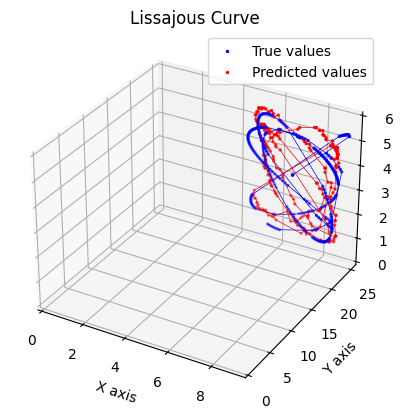

In [103]:
y_test_lis_pred, mse_lis, mae_lis, r2_lis = predict_evaluate_plot(X_scaled_test_lis, y_test_lis, model, scaler_y, 'Lissajous Curve')

Mean Squared Error on Test Data Set: 0.8216496699406274
Mean Absolute Error on Test Data Set: 0.6045421975153501
R2 Score on Test Data set: 0.30954468040003036


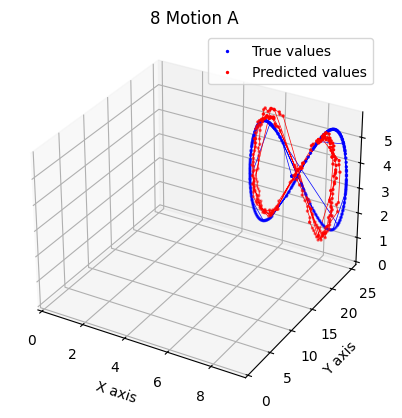

In [104]:
y_test_8_pred, mse_8, mae_8, r2_8 = predict_evaluate_plot(X_scaled_test_8, y_test_8, model, scaler_y, '8 Motion A')

## 6.4 Results
The results of the NN are better when i just drop the rows instead of using the interpolated data.

In [105]:
# make a df of all the motions and there respective mae, mse and r2
results = pd.DataFrame({
    'Motion': ['8 Motion', 'Lissajous Curve'],
    'MSE': [mse_8, mse_lis],
    'MAE': [mae_8, mae_lis],
    'R2': [r2_8, r2_lis]
})
results.set_index('Motion', inplace=True)
results

,MSE,MAE,R2
Motion,,,
8 Motion,0.821650,0.604542,0.309545
Lissajous Curve,0.773195,0.614928,0.610306
